In [112]:
from tensorflow.keras.models import load_model
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm
import wavio
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import pandas as pd
from librosa.core import resample, to_mono
from sklearn.metrics import precision_score, f1_score
from tensorflow.keras.utils import to_categorical

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean


def downsample_mono(path, sr):
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
        pass
    except Exception as exc:
        raise exc
    wav = resample(wav, orig_sr=rate, target_sr=sr)
    wav = wav.astype(np.int16)
    return sr, wav


def make_prediction(args):

    model = load_model(args.model_fn,
        custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})
    wav_paths = glob('{}/**'.format(args.src_dir), recursive=True)
    wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
    classes = sorted(os.listdir(args.src_dir))
    
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    le = LabelEncoder()
    y_true = le.fit_transform(labels)
    results = []

    for z, wav_fn in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        rate, wav = downsample_mono(wav_fn, args.sr)
        mask, env = envelope(wav, rate, threshold=args.threshold)
        clean_wav = wav[mask]
        step = int(args.sr*args.dt)
        batch = []

        for i in range(0, clean_wav.shape[0], step):
            sample = clean_wav[i:i+step]
            sample = sample.reshape(-1, 1)
            if sample.shape[0] < step:
                tmp = np.zeros(shape=(step, 1), dtype=np.float32)
                tmp[:sample.shape[0],:] = sample.flatten().reshape(-1, 1)
                sample = tmp
            batch.append(sample)
        X_batch = np.array(batch, dtype=np.float32)
        y_pred = model.predict(X_batch)
        y_mean = np.mean(y_pred-1, axis=0)
        y_pred = np.argmax(y_mean)
        print(f"y_pred index: {y_pred-1}, Number of classes: {len(classes)}")
        # Verify that y_pred is within the range of classes
        
        real_class = os.path.dirname(wav_fn).split('/')[-1]

        print('Actual class: {}, Predicted class: {}'.format(real_class, classes[y_pred-1]))
        results.append(y_mean)

    np.save(os.path.join('logs', args.pred_fn), np.array(results))


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_fn', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/models/conv2d.h5',
                        help='model file to make predictions')
    parser.add_argument('--pred_fn', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/logs/y_pred',
                        help='fn to write predictions in logs dir')
    parser.add_argument('--src_dir', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification_by_family',
                        help='directory containing wavfiles to predict')
    parser.add_argument('--dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=16000,
                        help='sample rate of clean audio')
    parser.add_argument('--threshold', type=str, default=20,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    make_prediction(args)


  0%|                                                  | 0/2913 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


  0%|                                          | 1/2913 [00:00<05:39,  8.57it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 11ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  0%|                                          | 5/2913 [00:00<02:12, 21.98it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  0%|                                          | 8/2913 [00:00<01:58, 24.57it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  0%|▏                                        | 11/2913 [00:00<01:50, 26.36it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  1%|▏                                        | 15/2913 [00:00<01:43, 28.14it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step


  1%|▎                                        | 19/2913 [00:00<01:39, 29.18it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  1%|▎                                        | 23/2913 [00:00<01:38, 29.44it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 30ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 97ms/step


  1%|▎                                        | 26/2913 [00:01<02:12, 21.83it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 29/2913 [00:01<02:02, 23.54it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 32/2913 [00:01<01:55, 24.98it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 35/2913 [00:01<01:50, 25.98it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  1%|▌                                        | 39/2913 [00:01<01:43, 27.77it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 11ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  1%|▌                                        | 43/2913 [00:01<01:39, 28.89it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step


  2%|▋                                        | 47/2913 [00:01<01:36, 29.68it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  2%|▋                                        | 51/2913 [00:01<01:36, 29.73it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  2%|▊                                        | 55/2913 [00:02<01:34, 30.40it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  2%|▊                                        | 59/2913 [00:02<01:33, 30.45it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step


  2%|▉                                        | 63/2913 [00:02<01:32, 30.74it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  2%|▉                                        | 67/2913 [00:02<01:30, 31.44it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  2%|▉                                        | 71/2913 [00:02<01:31, 31.07it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step


  3%|█                                        | 75/2913 [00:02<01:36, 29.52it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  3%|█                                        | 79/2913 [00:02<01:33, 30.33it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step


  3%|█▏                                       | 83/2913 [00:02<01:32, 30.45it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  3%|█▏                                       | 87/2913 [00:03<01:32, 30.52it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  3%|█▎                                       | 91/2913 [00:03<01:30, 31.18it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  3%|█▎                                       | 95/2913 [00:03<01:31, 30.88it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  3%|█▍                                       | 99/2913 [00:03<01:31, 30.75it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step


  4%|█▍                                      | 103/2913 [00:03<01:29, 31.49it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 13ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 12ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  4%|█▍                                      | 107/2913 [00:03<01:28, 31.54it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  4%|█▌                                      | 111/2913 [00:03<01:37, 28.80it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  4%|█▌                                      | 114/2913 [00:04<01:43, 27.02it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  4%|█▌                                      | 117/2913 [00:04<01:48, 25.80it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  4%|█▋                                      | 120/2913 [00:04<01:52, 24.73it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  4%|█▋                                      | 123/2913 [00:04<01:55, 24.06it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  4%|█▋                                      | 126/2913 [00:04<01:58, 23.54it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  4%|█▊                                      | 129/2913 [00:04<02:00, 23.19it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  5%|█▊                                      | 132/2913 [00:04<02:08, 21.61it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 135/2913 [00:04<02:06, 21.99it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  5%|█▉                                      | 138/2913 [00:05<02:03, 22.52it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  5%|█▉                                      | 141/2913 [00:05<02:03, 22.54it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  5%|█▉                                      | 144/2913 [00:05<02:03, 22.37it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  5%|██                                      | 147/2913 [00:05<02:03, 22.35it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  5%|██                                      | 150/2913 [00:05<02:03, 22.36it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  5%|██                                      | 153/2913 [00:05<02:02, 22.45it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 73ms/step


  5%|██▏                                     | 156/2913 [00:05<02:18, 19.90it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 21ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  5%|██▏                                     | 159/2913 [00:06<02:29, 18.47it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  6%|██▏                                     | 162/2913 [00:06<02:21, 19.43it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  6%|██▎                                     | 165/2913 [00:06<02:16, 20.15it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 168/2913 [00:06<02:10, 20.96it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  6%|██▎                                     | 171/2913 [00:06<02:08, 21.34it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  6%|██▍                                     | 174/2913 [00:06<02:06, 21.72it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  6%|██▍                                     | 177/2913 [00:06<02:04, 22.03it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 21ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  6%|██▍                                     | 180/2913 [00:07<02:03, 22.10it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  6%|██▌                                     | 183/2913 [00:07<02:03, 22.06it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  6%|██▌                                     | 186/2913 [00:07<02:02, 22.24it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  6%|██▌                                     | 189/2913 [00:07<02:01, 22.39it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  7%|██▋                                     | 192/2913 [00:07<01:59, 22.76it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▋                                     | 195/2913 [00:07<02:00, 22.60it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▋                                     | 198/2913 [00:07<02:01, 22.30it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  7%|██▊                                     | 201/2913 [00:08<02:00, 22.45it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 39ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▊                                     | 204/2913 [00:08<02:06, 21.35it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  7%|██▊                                     | 207/2913 [00:08<02:04, 21.67it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▉                                     | 210/2913 [00:08<02:03, 21.80it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▉                                     | 213/2913 [00:08<02:02, 22.00it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  7%|██▉                                     | 216/2913 [00:08<02:01, 22.11it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  8%|███                                     | 219/2913 [00:08<02:01, 22.24it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  8%|███                                     | 222/2913 [00:08<01:58, 22.69it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  8%|███                                     | 225/2913 [00:09<01:59, 22.51it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  8%|███▏                                    | 228/2913 [00:09<01:59, 22.45it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


  8%|███▏                                    | 231/2913 [00:09<02:01, 22.11it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  8%|███▏                                    | 234/2913 [00:09<02:00, 22.19it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


  8%|███▎                                    | 237/2913 [00:09<02:00, 22.12it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


  8%|███▎                                    | 240/2913 [00:09<02:00, 22.09it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  8%|███▎                                    | 243/2913 [00:09<01:56, 22.87it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  8%|███▍                                    | 246/2913 [00:10<01:52, 23.75it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  9%|███▍                                    | 249/2913 [00:10<01:53, 23.54it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  9%|███▍                                    | 252/2913 [00:10<01:56, 22.86it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 255/2913 [00:10<01:55, 23.10it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 258/2913 [00:10<01:53, 23.46it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 261/2913 [00:10<01:51, 23.89it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


  9%|███▋                                    | 264/2913 [00:10<01:48, 24.38it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  9%|███▋                                    | 267/2913 [00:10<01:47, 24.56it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


  9%|███▋                                    | 270/2913 [00:11<01:46, 24.80it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 273/2913 [00:11<01:47, 24.59it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 276/2913 [00:11<01:47, 24.43it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 279/2913 [00:11<01:47, 24.52it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 282/2913 [00:11<01:48, 24.23it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 24ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 285/2913 [00:11<02:02, 21.44it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 21ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 288/2913 [00:11<02:00, 21.75it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 291/2913 [00:11<01:58, 22.15it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 10%|████                                    | 294/2913 [00:12<01:53, 23.09it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 297/2913 [00:12<01:48, 24.20it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 10%|████                                    | 300/2913 [00:12<01:48, 24.05it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 303/2913 [00:12<01:48, 24.05it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 11%|████▏                                   | 306/2913 [00:12<01:44, 24.91it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 11%|████▏                                   | 309/2913 [00:12<01:44, 24.87it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 312/2913 [00:12<01:44, 24.83it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 11%|████▎                                   | 315/2913 [00:12<01:41, 25.49it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 11%|████▎                                   | 318/2913 [00:13<01:42, 25.21it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 321/2913 [00:13<01:43, 24.97it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 11%|████▍                                   | 324/2913 [00:13<01:40, 25.78it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


 11%|████▍                                   | 327/2913 [00:13<01:41, 25.40it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 11%|████▌                                   | 330/2913 [00:13<01:47, 24.05it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 11%|████▌                                   | 333/2913 [00:13<01:45, 24.41it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 12%|████▌                                   | 336/2913 [00:13<01:46, 24.29it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step


 12%|████▋                                   | 339/2913 [00:13<01:44, 24.58it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 15ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 14ms/step


 12%|████▋                                   | 342/2913 [00:13<01:41, 25.28it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 24ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 345/2913 [00:14<01:44, 24.58it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 348/2913 [00:14<01:45, 24.40it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 351/2913 [00:14<01:45, 24.23it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 354/2913 [00:14<01:46, 23.95it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 12%|████▉                                   | 357/2913 [00:14<01:46, 23.94it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 12%|████▉                                   | 360/2913 [00:14<01:47, 23.86it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 12%|████▉                                   | 363/2913 [00:14<01:49, 23.34it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 13%|█████                                   | 366/2913 [00:15<01:51, 22.76it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 13%|█████                                   | 369/2913 [00:15<01:53, 22.38it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 13%|█████                                   | 372/2913 [00:15<01:54, 22.26it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 21ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 13%|█████▏                                  | 375/2913 [00:15<01:54, 22.18it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 13%|█████▏                                  | 378/2913 [00:15<01:55, 21.96it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 13%|█████▏                                  | 381/2913 [00:15<01:55, 21.88it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 384/2913 [00:15<01:53, 22.23it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 387/2913 [00:15<01:52, 22.49it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 13%|█████▎                                  | 390/2913 [00:16<01:52, 22.36it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 13%|█████▍                                  | 393/2913 [00:16<01:53, 22.14it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 21ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 14%|█████▍                                  | 396/2913 [00:16<01:54, 21.94it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 399/2913 [00:16<01:54, 21.91it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 14%|█████▌                                  | 402/2913 [00:16<01:57, 21.28it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 405/2913 [00:16<01:54, 21.88it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 14%|█████▌                                  | 408/2913 [00:16<01:53, 22.04it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 14%|█████▋                                  | 411/2913 [00:17<01:53, 22.05it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 23ms/step


 14%|█████▋                                  | 414/2913 [00:17<01:52, 22.13it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 14%|█████▋                                  | 417/2913 [00:17<01:52, 22.27it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 14%|█████▊                                  | 420/2913 [00:17<01:52, 22.16it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 15%|█████▊                                  | 423/2913 [00:17<01:53, 21.96it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 15%|█████▊                                  | 426/2913 [00:17<01:52, 22.14it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 15%|█████▉                                  | 429/2913 [00:17<01:51, 22.29it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 432/2913 [00:18<01:50, 22.40it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step


 15%|█████▉                                  | 435/2913 [00:18<01:50, 22.39it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 15%|██████                                  | 438/2913 [00:18<01:50, 22.33it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 441/2913 [00:18<01:51, 22.21it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 15%|██████                                  | 444/2913 [00:18<01:51, 22.15it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step


 15%|██████▏                                 | 447/2913 [00:18<01:50, 22.26it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 18ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 20ms/step


 15%|██████▏                                 | 450/2913 [00:18<01:50, 22.29it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 17ms/step


 16%|██████▏                                 | 453/2913 [00:18<01:48, 22.57it/s]

y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 19ms/step
y_pred index: 0, Number of classes: 4
Actual class: Brass, Predicted class: Brass
1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 456/2913 [00:19<01:49, 22.50it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 459/2913 [00:19<01:47, 22.80it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 16%|██████▎                                 | 462/2913 [00:19<01:44, 23.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 16%|██████▍                                 | 465/2913 [00:19<01:45, 23.14it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 16%|██████▍                                 | 468/2913 [00:19<01:45, 23.09it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 16%|██████▍                                 | 471/2913 [00:19<01:45, 23.10it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 23ms/step


 16%|██████▌                                 | 474/2913 [00:19<01:49, 22.25it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 16%|██████▌                                 | 477/2913 [00:20<01:54, 21.21it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 16%|██████▌                                 | 480/2913 [00:20<01:51, 21.81it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 17%|██████▋                                 | 483/2913 [00:20<01:45, 22.93it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                 | 486/2913 [00:20<01:48, 22.39it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 489/2913 [00:20<01:46, 22.82it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 17%|██████▊                                 | 492/2913 [00:20<01:44, 23.09it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 495/2913 [00:20<01:44, 23.06it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 17%|██████▊                                 | 498/2913 [00:20<01:47, 22.45it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 17%|██████▉                                 | 501/2913 [00:21<01:49, 21.96it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 17%|██████▉                                 | 504/2913 [00:21<01:50, 21.79it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 17%|██████▉                                 | 507/2913 [00:21<01:48, 22.24it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 18%|███████                                 | 510/2913 [00:21<01:44, 23.02it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 18%|███████                                 | 513/2913 [00:21<01:45, 22.76it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 18%|███████                                 | 516/2913 [00:21<01:45, 22.64it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 18%|███████▏                                | 519/2913 [00:21<01:46, 22.45it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 18%|███████▏                                | 522/2913 [00:22<01:46, 22.44it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 18%|███████▏                                | 525/2913 [00:22<01:46, 22.40it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 27ms/step


 18%|███████▎                                | 528/2913 [00:22<01:53, 21.08it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step


 18%|███████▎                                | 531/2913 [00:22<01:48, 21.86it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 18%|███████▎                                | 534/2913 [00:22<01:47, 22.15it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 18%|███████▎                                | 537/2913 [00:22<01:46, 22.40it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 19%|███████▍                                | 540/2913 [00:22<01:47, 22.17it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 19%|███████▍                                | 543/2913 [00:22<01:47, 22.13it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 19%|███████▍                                | 546/2913 [00:23<01:44, 22.58it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 19%|███████▌                                | 549/2913 [00:23<01:50, 21.48it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 19%|███████▌                                | 552/2913 [00:23<01:47, 21.99it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 19%|███████▌                                | 555/2913 [00:23<01:44, 22.46it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 19%|███████▋                                | 558/2913 [00:23<01:44, 22.47it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 19%|███████▋                                | 561/2913 [00:23<01:44, 22.54it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step


 19%|███████▋                                | 564/2913 [00:23<01:40, 23.33it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 19%|███████▊                                | 567/2913 [00:24<01:40, 23.45it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 20%|███████▊                                | 570/2913 [00:24<01:40, 23.26it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 20%|███████▊                                | 573/2913 [00:24<01:40, 23.24it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 20%|███████▉                                | 576/2913 [00:24<01:41, 23.02it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 20%|███████▉                                | 579/2913 [00:24<01:40, 23.18it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 20%|███████▉                                | 582/2913 [00:24<01:38, 23.57it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 24ms/step


 20%|████████                                | 585/2913 [00:24<01:44, 22.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 20%|████████                                | 588/2913 [00:24<01:44, 22.27it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 20%|████████                                | 591/2913 [00:25<01:42, 22.64it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 20%|████████▏                               | 594/2913 [00:25<01:40, 23.09it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 23ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 20%|████████▏                               | 597/2913 [00:25<01:43, 22.29it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 21%|████████▏                               | 600/2913 [00:25<01:41, 22.80it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 21%|████████▎                               | 603/2913 [00:25<01:40, 22.92it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step


 21%|████████▎                               | 606/2913 [00:25<01:40, 22.93it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 21%|████████▎                               | 609/2913 [00:25<01:42, 22.54it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 21%|████████▍                               | 612/2913 [00:26<01:43, 22.13it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 21%|████████▍                               | 615/2913 [00:26<01:43, 22.30it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 38ms/step


 21%|████████▍                               | 618/2913 [00:26<01:47, 21.38it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 21%|████████▌                               | 621/2913 [00:26<01:43, 22.23it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 21%|████████▌                               | 624/2913 [00:26<01:44, 21.94it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 22%|████████▌                               | 627/2913 [00:26<01:42, 22.20it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 22%|████████▋                               | 630/2913 [00:26<01:41, 22.41it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 22%|████████▋                               | 633/2913 [00:26<01:41, 22.50it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 22%|████████▋                               | 636/2913 [00:27<01:39, 22.99it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 22%|████████▊                               | 639/2913 [00:27<01:37, 23.34it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 22%|████████▊                               | 642/2913 [00:27<01:39, 22.72it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 22%|████████▊                               | 645/2913 [00:27<01:38, 22.97it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 22%|████████▉                               | 648/2913 [00:27<01:39, 22.87it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 22%|████████▉                               | 651/2913 [00:27<01:38, 23.05it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 22%|████████▉                               | 654/2913 [00:27<01:38, 22.92it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 23%|█████████                               | 657/2913 [00:27<01:37, 23.16it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 23%|█████████                               | 660/2913 [00:28<01:34, 23.86it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 23%|█████████                               | 663/2913 [00:28<01:34, 23.79it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 23%|█████████▏                              | 666/2913 [00:28<01:35, 23.47it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 23%|█████████▏                              | 669/2913 [00:28<01:36, 23.29it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 23%|█████████▏                              | 672/2913 [00:28<01:34, 23.66it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 23%|█████████▎                              | 675/2913 [00:28<01:35, 23.49it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 23%|█████████▎                              | 678/2913 [00:28<01:35, 23.37it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 23%|█████████▎                              | 681/2913 [00:28<01:35, 23.31it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 23%|█████████▍                              | 684/2913 [00:29<01:38, 22.61it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                              | 687/2913 [00:29<01:38, 22.68it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                              | 690/2913 [00:29<01:41, 21.80it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                              | 693/2913 [00:29<01:41, 21.95it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                              | 696/2913 [00:29<01:38, 22.40it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 24%|█████████▌                              | 699/2913 [00:29<01:41, 21.75it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 24%|█████████▋                              | 702/2913 [00:29<01:41, 21.83it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 24%|█████████▋                              | 705/2913 [00:30<01:37, 22.59it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 24%|█████████▋                              | 708/2913 [00:30<01:35, 23.01it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 24%|█████████▊                              | 711/2913 [00:30<01:35, 23.10it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 25%|█████████▊                              | 714/2913 [00:30<01:38, 22.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step


 25%|█████████▊                              | 717/2913 [00:30<01:36, 22.78it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 25%|█████████▉                              | 720/2913 [00:30<01:34, 23.15it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 25%|█████████▉                              | 723/2913 [00:30<01:36, 22.71it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                              | 726/2913 [00:31<01:38, 22.12it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 25%|██████████                              | 729/2913 [00:31<01:37, 22.32it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 25%|██████████                              | 732/2913 [00:31<01:36, 22.51it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 25%|██████████                              | 735/2913 [00:31<01:35, 22.80it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 25%|██████████▏                             | 738/2913 [00:31<01:35, 22.75it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 25%|██████████▏                             | 741/2913 [00:31<01:33, 23.19it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                             | 744/2913 [00:31<01:34, 22.96it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                             | 747/2913 [00:31<01:33, 23.19it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 26%|██████████▎                             | 750/2913 [00:32<01:35, 22.75it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 26%|██████████▎                             | 753/2913 [00:32<01:35, 22.60it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 26%|██████████▍                             | 756/2913 [00:32<01:37, 22.17it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 26%|██████████▍                             | 759/2913 [00:32<01:36, 22.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 35ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 26%|██████████▍                             | 762/2913 [00:32<01:40, 21.47it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 26%|██████████▌                             | 765/2913 [00:32<01:37, 22.02it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 26%|██████████▌                             | 768/2913 [00:32<01:36, 22.29it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 26%|██████████▌                             | 771/2913 [00:33<01:33, 22.91it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 27%|██████████▋                             | 774/2913 [00:33<01:34, 22.59it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                             | 777/2913 [00:33<01:32, 23.17it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                             | 780/2913 [00:33<01:31, 23.38it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 27%|██████████▊                             | 783/2913 [00:33<01:31, 23.31it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 27%|██████████▊                             | 786/2913 [00:33<01:29, 23.72it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 27%|██████████▊                             | 789/2913 [00:33<01:30, 23.39it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 27%|██████████▉                             | 792/2913 [00:33<01:31, 23.20it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 27%|██████████▉                             | 795/2913 [00:34<01:31, 23.14it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 27%|██████████▉                             | 798/2913 [00:34<01:34, 22.49it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 27%|██████████▉                             | 801/2913 [00:34<01:34, 22.24it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 28%|███████████                             | 804/2913 [00:34<01:35, 22.00it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 28%|███████████                             | 807/2913 [00:34<01:32, 22.68it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 28%|███████████                             | 810/2913 [00:34<01:34, 22.31it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 28%|███████████▏                            | 813/2913 [00:34<01:34, 22.32it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 28%|███████████▏                            | 816/2913 [00:34<01:33, 22.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 28%|███████████▏                            | 819/2913 [00:35<01:33, 22.43it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 28%|███████████▎                            | 822/2913 [00:35<01:32, 22.70it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 28%|███████████▎                            | 825/2913 [00:35<01:33, 22.37it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 28%|███████████▎                            | 828/2913 [00:35<01:32, 22.62it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                            | 831/2913 [00:35<01:36, 21.62it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 29%|███████████▍                            | 834/2913 [00:35<01:38, 21.12it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                            | 837/2913 [00:35<01:38, 21.11it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▌                            | 840/2913 [00:36<01:37, 21.32it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▌                            | 843/2913 [00:36<01:35, 21.71it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▌                            | 846/2913 [00:36<01:33, 22.00it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 29%|███████████▋                            | 849/2913 [00:36<01:31, 22.60it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 29%|███████████▋                            | 852/2913 [00:36<01:33, 22.06it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 23ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 29%|███████████▋                            | 855/2913 [00:36<01:35, 21.53it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 29%|███████████▊                            | 858/2913 [00:36<01:34, 21.70it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                            | 861/2913 [00:37<01:33, 21.99it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                            | 864/2913 [00:37<01:32, 22.05it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 285ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 26ms/step


 30%|███████████▉                            | 867/2913 [00:37<02:38, 12.90it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 44ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 30ms/step


 30%|███████████▉                            | 869/2913 [00:37<02:37, 12.98it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step


 30%|███████████▉                            | 871/2913 [00:37<02:30, 13.60it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step


 30%|████████████                            | 874/2913 [00:38<02:28, 13.71it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 39ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 30%|████████████                            | 876/2913 [00:38<02:21, 14.41it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 30%|████████████                            | 878/2913 [00:38<02:12, 15.38it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 21ms/step


 30%|████████████                            | 880/2913 [00:38<02:06, 16.02it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 21ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step


 30%|████████████                            | 882/2913 [00:38<02:04, 16.35it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 30%|████████████▏                           | 884/2913 [00:38<02:02, 16.61it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 30%|████████████▏                           | 887/2913 [00:38<01:51, 18.23it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step


 31%|████████████▏                           | 889/2913 [00:38<01:51, 18.12it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 79ms/step


 31%|████████████▏                           | 891/2913 [00:39<02:08, 15.77it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 90ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 31%|████████████▎                           | 893/2913 [00:39<02:29, 13.47it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 31%|████████████▎                           | 895/2913 [00:39<02:27, 13.65it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 31%|████████████▎                           | 898/2913 [00:39<02:03, 16.30it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                           | 901/2913 [00:39<01:52, 17.89it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 33ms/step


 31%|████████████▍                           | 903/2913 [00:39<01:51, 18.01it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 21ms/step


 31%|████████████▍                           | 905/2913 [00:39<01:49, 18.32it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 45ms/step


 31%|████████████▍                           | 907/2913 [00:40<02:21, 14.16it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step


 31%|████████████▍                           | 910/2913 [00:40<02:04, 16.07it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 31%|████████████▌                           | 913/2913 [00:40<01:54, 17.46it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 21ms/step


 31%|████████████▌                           | 915/2913 [00:40<01:54, 17.38it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 89ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 23ms/step


 31%|████████████▌                           | 917/2913 [00:40<02:27, 13.51it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step


 32%|████████████▌                           | 919/2913 [00:40<02:21, 14.08it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 32ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 32%|████████████▋                           | 921/2913 [00:41<02:26, 13.63it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 24ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 32%|████████████▋                           | 924/2913 [00:41<02:07, 15.64it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 32%|████████████▋                           | 927/2913 [00:41<01:53, 17.43it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 32%|████████████▊                           | 930/2913 [00:41<01:46, 18.60it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 32%|████████████▊                           | 932/2913 [00:41<01:45, 18.76it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 32%|████████████▊                           | 935/2913 [00:41<01:39, 19.89it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 22ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 24ms/step


 32%|████████████▉                           | 938/2913 [00:41<01:48, 18.25it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 32%|████████████▉                           | 941/2913 [00:42<01:42, 19.30it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 32%|████████████▉                           | 944/2913 [00:42<01:37, 20.13it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 33%|█████████████                           | 947/2913 [00:42<01:35, 20.49it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 33%|█████████████                           | 950/2913 [00:42<01:32, 21.24it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 33%|█████████████                           | 953/2913 [00:42<01:30, 21.59it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 33%|█████████████▏                          | 956/2913 [00:42<01:31, 21.40it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 33%|█████████████▏                          | 959/2913 [00:42<01:29, 21.86it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 33%|█████████████▏                          | 962/2913 [00:43<01:28, 22.13it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 33%|█████████████▎                          | 965/2913 [00:43<01:26, 22.63it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 33%|█████████████▎                          | 968/2913 [00:43<01:25, 22.64it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 33%|█████████████▎                          | 971/2913 [00:43<01:26, 22.57it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 33%|█████████████▎                          | 974/2913 [00:43<01:24, 23.05it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 34%|█████████████▍                          | 977/2913 [00:43<01:25, 22.68it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                          | 980/2913 [00:43<01:26, 22.40it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                          | 983/2913 [00:43<01:27, 22.03it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 34%|█████████████▌                          | 986/2913 [00:44<01:29, 21.41it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 34%|█████████████▌                          | 989/2913 [00:44<01:32, 20.71it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 34%|█████████████▌                          | 992/2913 [00:44<01:35, 20.16it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 34%|█████████████▋                          | 995/2913 [00:44<01:32, 20.80it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 34%|█████████████▋                          | 998/2913 [00:44<01:30, 21.19it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 1001/2913 [00:44<01:29, 21.29it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 1004/2913 [00:44<01:30, 21.13it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 35%|█████████████▍                         | 1007/2913 [00:45<01:27, 21.75it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 1010/2913 [00:45<01:24, 22.39it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 35%|█████████████▌                         | 1013/2913 [00:45<01:23, 22.68it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 1016/2913 [00:45<01:28, 21.53it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 1019/2913 [00:45<01:27, 21.76it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 1022/2913 [00:45<01:27, 21.70it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 35%|█████████████▋                         | 1025/2913 [00:45<01:27, 21.66it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 35%|█████████████▊                         | 1028/2913 [00:46<01:26, 21.70it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 1031/2913 [00:46<01:26, 21.72it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 1034/2913 [00:46<01:26, 21.85it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 1037/2913 [00:46<01:26, 21.74it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 36%|█████████████▉                         | 1040/2913 [00:46<01:26, 21.73it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 36%|█████████████▉                         | 1043/2913 [00:46<01:24, 22.08it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 23ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 36%|██████████████                         | 1046/2913 [00:46<01:28, 21.07it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 1049/2913 [00:47<01:28, 21.16it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 1052/2913 [00:47<01:27, 21.24it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 1055/2913 [00:47<01:25, 21.74it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 20ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 36%|██████████████▏                        | 1058/2913 [00:47<01:27, 21.27it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 36%|██████████████▏                        | 1061/2913 [00:47<01:25, 21.78it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 37%|██████████████▏                        | 1064/2913 [00:47<01:27, 21.22it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 1067/2913 [00:47<01:24, 21.96it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 21ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 37%|██████████████▎                        | 1070/2913 [00:48<01:25, 21.58it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 37%|██████████████▎                        | 1073/2913 [00:48<01:23, 22.16it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 37%|██████████████▍                        | 1076/2913 [00:48<01:22, 22.30it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 37%|██████████████▍                        | 1079/2913 [00:48<01:23, 22.00it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 37%|██████████████▍                        | 1082/2913 [00:48<01:20, 22.76it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 37%|██████████████▌                        | 1085/2913 [00:48<01:19, 23.02it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 37%|██████████████▌                        | 1088/2913 [00:48<01:17, 23.44it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step


 37%|██████████████▌                        | 1091/2913 [00:48<01:17, 23.59it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 1094/2913 [00:49<01:21, 22.28it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 1097/2913 [00:49<01:22, 22.01it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 38%|██████████████▋                        | 1100/2913 [00:49<01:20, 22.66it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 29ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 38%|██████████████▊                        | 1103/2913 [00:49<01:27, 20.64it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 1106/2913 [00:49<01:26, 20.92it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 1109/2913 [00:49<01:25, 21.18it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 25ms/step


 38%|██████████████▉                        | 1112/2913 [00:49<01:27, 20.68it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 38%|██████████████▉                        | 1115/2913 [00:50<01:25, 21.09it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 1118/2913 [00:50<01:22, 21.70it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step


 38%|███████████████                        | 1121/2913 [00:50<01:18, 22.73it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 39%|███████████████                        | 1124/2913 [00:50<01:19, 22.63it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 19ms/step


 39%|███████████████                        | 1127/2913 [00:50<01:17, 22.97it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 13ms/step


 39%|███████████████▏                       | 1130/2913 [00:50<01:15, 23.46it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 39%|███████████████▏                       | 1133/2913 [00:50<01:15, 23.73it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 1136/2913 [00:50<01:16, 23.31it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 58ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 39%|███████████████▏                       | 1139/2913 [00:51<01:29, 19.76it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 1142/2913 [00:51<01:25, 20.60it/s]

y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 14ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 15ms/step
y_pred index: 1, Number of classes: 4
Actual class: Keyboards, Predicted class: Keyboards
1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 1145/2913 [00:51<01:21, 21.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 39%|███████████████▎                       | 1148/2913 [00:51<01:23, 21.10it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step


 40%|███████████████▍                       | 1151/2913 [00:51<01:24, 20.93it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 40%|███████████████▍                       | 1154/2913 [00:51<01:17, 22.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 40%|███████████████▍                       | 1157/2913 [00:51<01:16, 22.83it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 40%|███████████████▌                       | 1160/2913 [00:52<01:18, 22.38it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 40%|███████████████▌                       | 1163/2913 [00:52<01:20, 21.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 1166/2913 [00:52<01:15, 23.03it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 40%|███████████████▋                       | 1169/2913 [00:52<01:13, 23.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 24ms/step


 40%|███████████████▋                       | 1172/2913 [00:52<01:16, 22.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 40%|███████████████▋                       | 1175/2913 [00:52<01:20, 21.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▊                       | 1178/2913 [00:52<01:24, 20.59it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 67ms/step


 41%|███████████████▊                       | 1181/2913 [00:53<01:34, 18.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 41%|███████████████▊                       | 1183/2913 [00:53<01:36, 17.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 41%|███████████████▉                       | 1186/2913 [00:53<01:31, 18.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step


 41%|███████████████▉                       | 1189/2913 [00:53<01:28, 19.48it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 41%|███████████████▉                       | 1192/2913 [00:53<01:26, 19.94it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 41%|███████████████▉                       | 1195/2913 [00:53<01:22, 20.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 1198/2913 [00:53<01:16, 22.29it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 1201/2913 [00:54<01:18, 21.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 41%|████████████████                       | 1204/2913 [00:54<01:21, 20.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 41%|████████████████▏                      | 1207/2913 [00:54<01:17, 22.04it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 42%|████████████████▏                      | 1210/2913 [00:54<01:16, 22.33it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 42%|████████████████▏                      | 1213/2913 [00:54<01:16, 22.10it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 42%|████████████████▎                      | 1216/2913 [00:54<01:19, 21.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 1219/2913 [00:54<01:16, 22.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 42%|████████████████▎                      | 1222/2913 [00:55<01:15, 22.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 1225/2913 [00:55<01:11, 23.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 42%|████████████████▍                      | 1228/2913 [00:55<01:11, 23.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 42%|████████████████▍                      | 1231/2913 [00:55<01:13, 22.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 42%|████████████████▌                      | 1234/2913 [00:55<01:10, 23.94it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 42%|████████████████▌                      | 1237/2913 [00:55<01:09, 23.96it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▌                      | 1240/2913 [00:55<01:13, 22.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 1243/2913 [00:55<01:15, 22.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 1246/2913 [00:56<01:11, 23.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 43%|████████████████▋                      | 1249/2913 [00:56<01:11, 23.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▊                      | 1252/2913 [00:56<01:11, 23.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 43%|████████████████▊                      | 1255/2913 [00:56<01:14, 22.37it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 1258/2913 [00:56<01:11, 23.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 30ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▉                      | 1261/2913 [00:56<01:12, 22.72it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 1264/2913 [00:56<01:10, 23.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 43%|████████████████▉                      | 1267/2913 [00:56<01:09, 23.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 1270/2913 [00:57<01:08, 24.02it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 1273/2913 [00:57<01:07, 24.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 44%|█████████████████                      | 1276/2913 [00:57<01:04, 25.55it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 44%|█████████████████                      | 1279/2913 [00:57<01:04, 25.47it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 1282/2913 [00:57<01:05, 24.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 40ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 44%|█████████████████▏                     | 1285/2913 [00:57<01:12, 22.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▏                     | 1288/2913 [00:57<01:08, 23.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 1291/2913 [00:57<01:07, 23.97it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 44%|█████████████████▎                     | 1294/2913 [00:58<01:06, 24.31it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 45%|█████████████████▎                     | 1297/2913 [00:58<01:08, 23.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 1300/2913 [00:58<01:05, 24.48it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 1303/2913 [00:58<01:09, 23.11it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 1306/2913 [00:58<01:12, 22.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▌                     | 1309/2913 [00:58<01:16, 21.08it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▌                     | 1312/2913 [00:58<01:12, 22.08it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▌                     | 1315/2913 [00:58<01:10, 22.57it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 1318/2913 [00:59<01:08, 23.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 1321/2913 [00:59<01:09, 22.97it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▋                     | 1324/2913 [00:59<01:06, 23.97it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▊                     | 1327/2913 [00:59<01:04, 24.41it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 25ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▊                     | 1330/2913 [00:59<01:16, 20.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings


 46%|█████████████████▊                     | 1333/2913 [00:59<01:13, 21.38it/s]

1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 46%|█████████████████▉                     | 1336/2913 [00:59<01:12, 21.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 46%|█████████████████▉                     | 1339/2913 [01:00<01:14, 21.12it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 1342/2913 [01:00<01:10, 22.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 1345/2913 [01:00<01:08, 22.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 46%|██████████████████                     | 1348/2913 [01:00<01:10, 22.33it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 1351/2913 [01:00<01:06, 23.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step


 46%|██████████████████▏                    | 1354/2913 [01:00<01:15, 20.72it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 1357/2913 [01:00<01:11, 21.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▏                    | 1360/2913 [01:01<01:10, 21.98it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▏                    | 1363/2913 [01:01<01:10, 22.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▎                    | 1366/2913 [01:01<01:05, 23.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▎                    | 1369/2913 [01:01<01:03, 24.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▎                    | 1372/2913 [01:01<01:02, 24.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 12ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 47%|██████████████████▍                    | 1375/2913 [01:01<01:00, 25.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step


 47%|██████████████████▍                    | 1378/2913 [01:01<01:08, 22.52it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▍                    | 1381/2913 [01:01<01:06, 23.08it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 1384/2913 [01:02<01:05, 23.25it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▌                    | 1387/2913 [01:02<01:06, 22.81it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 48%|██████████████████▌                    | 1390/2913 [01:02<01:03, 24.16it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 48%|██████████████████▋                    | 1393/2913 [01:02<01:01, 24.67it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 48%|██████████████████▋                    | 1396/2913 [01:02<01:01, 24.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step


 48%|██████████████████▋                    | 1399/2913 [01:02<01:00, 24.91it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step


 48%|██████████████████▊                    | 1402/2913 [01:02<01:04, 23.31it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 1405/2913 [01:02<01:03, 23.83it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 48%|██████████████████▊                    | 1408/2913 [01:02<01:02, 24.12it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 1411/2913 [01:03<01:01, 24.51it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 49%|██████████████████▉                    | 1414/2913 [01:03<01:02, 23.89it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step


 49%|██████████████████▉                    | 1417/2913 [01:03<00:59, 25.23it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 1420/2913 [01:03<00:58, 25.44it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 1423/2913 [01:03<00:59, 25.08it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 1426/2913 [01:03<00:57, 25.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step


 49%|███████████████████▏                   | 1429/2913 [01:03<01:03, 23.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▏                   | 1432/2913 [01:04<01:08, 21.72it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▏                   | 1435/2913 [01:04<01:07, 21.91it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▎                   | 1438/2913 [01:04<01:06, 22.06it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▎                   | 1441/2913 [01:04<01:06, 22.13it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 1444/2913 [01:04<01:02, 23.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 1447/2913 [01:04<01:01, 23.88it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 14ms/step


 50%|███████████████████▍                   | 1450/2913 [01:04<01:00, 24.29it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 13ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▍                   | 1453/2913 [01:04<00:57, 25.19it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▍                   | 1456/2913 [01:05<01:01, 23.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▌                   | 1459/2913 [01:05<01:04, 22.47it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▌                   | 1462/2913 [01:05<01:06, 21.92it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▌                   | 1465/2913 [01:05<01:08, 21.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▋                   | 1468/2913 [01:05<01:08, 21.11it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▋                   | 1471/2913 [01:05<01:08, 21.02it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▋                   | 1474/2913 [01:05<01:09, 20.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▊                   | 1477/2913 [01:06<01:08, 20.94it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 1480/2913 [01:06<01:07, 21.08it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 51%|███████████████████▊                   | 1483/2913 [01:06<01:09, 20.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 51%|███████████████████▉                   | 1486/2913 [01:06<01:10, 20.35it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 51%|███████████████████▉                   | 1489/2913 [01:06<01:11, 19.97it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 1492/2913 [01:06<01:10, 20.02it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 51%|████████████████████                   | 1495/2913 [01:06<01:09, 20.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 51%|████████████████████                   | 1498/2913 [01:07<01:12, 19.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 52%|████████████████████                   | 1501/2913 [01:07<01:11, 19.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 1504/2913 [01:07<01:10, 20.03it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▏                  | 1507/2913 [01:07<01:10, 19.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 52%|████████████████████▏                  | 1509/2913 [01:07<01:14, 18.92it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 1512/2913 [01:07<01:11, 19.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▎                  | 1515/2913 [01:07<01:10, 19.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 52%|████████████████████▎                  | 1517/2913 [01:08<01:10, 19.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 25ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▎                  | 1519/2913 [01:08<01:10, 19.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 30ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 52%|████████████████████▎                  | 1521/2913 [01:08<01:15, 18.35it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▍                  | 1524/2913 [01:08<01:12, 19.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▍                  | 1526/2913 [01:08<01:11, 19.28it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▍                  | 1529/2913 [01:08<01:09, 19.80it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▌                  | 1532/2913 [01:08<01:11, 19.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▌                  | 1535/2913 [01:08<01:09, 19.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▌                  | 1538/2913 [01:09<01:09, 19.89it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1541/2913 [01:09<01:07, 20.28it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1544/2913 [01:09<01:06, 20.47it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1547/2913 [01:09<01:06, 20.48it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 1550/2913 [01:09<01:06, 20.44it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 1553/2913 [01:09<01:05, 20.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 25ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 1556/2913 [01:10<01:08, 19.76it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▊                  | 1559/2913 [01:10<01:08, 19.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 1562/2913 [01:10<01:07, 19.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 1565/2913 [01:10<01:06, 20.18it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 24ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 1568/2913 [01:10<01:06, 20.12it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 1571/2913 [01:10<01:06, 20.16it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 1574/2913 [01:10<01:05, 20.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 1577/2913 [01:11<01:05, 20.43it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████▏                 | 1580/2913 [01:11<01:08, 19.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 1582/2913 [01:11<01:15, 17.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 1585/2913 [01:11<01:11, 18.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 1588/2913 [01:11<01:08, 19.35it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 1591/2913 [01:11<01:07, 19.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▎                 | 1593/2913 [01:11<01:07, 19.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 1595/2913 [01:12<01:07, 19.67it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▍                 | 1598/2913 [01:12<01:06, 19.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 1601/2913 [01:12<01:04, 20.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▍                 | 1604/2913 [01:12<01:04, 20.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 1607/2913 [01:12<01:03, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 1610/2913 [01:12<01:02, 20.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 1613/2913 [01:12<01:02, 20.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▋                 | 1616/2913 [01:13<01:06, 19.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████▋                 | 1618/2913 [01:13<01:06, 19.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▋                 | 1620/2913 [01:13<01:07, 19.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████▋                 | 1622/2913 [01:13<01:06, 19.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings


 56%|█████████████████████▊                 | 1625/2913 [01:13<01:05, 19.76it/s]

1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████▊                 | 1627/2913 [01:13<01:05, 19.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings


 56%|█████████████████████▊                 | 1630/2913 [01:13<01:04, 19.89it/s]

1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▊                 | 1633/2913 [01:13<01:02, 20.36it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████▉                 | 1636/2913 [01:14<01:02, 20.52it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▉                 | 1639/2913 [01:14<01:02, 20.46it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 1642/2913 [01:14<01:01, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 56%|██████████████████████                 | 1645/2913 [01:14<01:01, 20.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 1648/2913 [01:14<01:01, 20.66it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 1651/2913 [01:14<01:00, 20.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 1654/2913 [01:14<01:00, 20.71it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▏                | 1657/2913 [01:15<01:00, 20.71it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 1660/2913 [01:15<01:00, 20.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▎                | 1663/2913 [01:15<00:59, 20.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▎                | 1666/2913 [01:15<01:00, 20.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▎                | 1669/2913 [01:15<00:59, 20.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▍                | 1672/2913 [01:15<01:00, 20.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▍                | 1675/2913 [01:15<00:59, 20.78it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▍                | 1678/2913 [01:16<01:02, 19.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▌                | 1681/2913 [01:16<01:00, 20.25it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 1684/2913 [01:16<01:00, 20.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 1687/2913 [01:16<00:59, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▋                | 1690/2913 [01:16<00:59, 20.67it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▋                | 1693/2913 [01:16<00:59, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▋                | 1696/2913 [01:16<00:58, 20.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▋                | 1699/2913 [01:17<00:58, 20.69it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▊                | 1702/2913 [01:17<00:58, 20.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 59%|██████████████████████▊                | 1705/2913 [01:17<00:58, 20.55it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 59%|██████████████████████▊                | 1708/2913 [01:17<00:58, 20.60it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 59%|██████████████████████▉                | 1711/2913 [01:17<00:57, 20.80it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 1714/2913 [01:17<00:58, 20.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 1717/2913 [01:17<00:57, 20.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████                | 1720/2913 [01:18<00:57, 20.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████                | 1723/2913 [01:18<00:57, 20.69it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████                | 1726/2913 [01:18<00:57, 20.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████▏               | 1729/2913 [01:18<00:57, 20.77it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 1732/2913 [01:18<00:56, 20.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▏               | 1735/2913 [01:18<00:56, 20.98it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 1738/2913 [01:19<00:57, 20.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 1741/2913 [01:19<00:57, 20.23it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 1744/2913 [01:19<00:57, 20.33it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 1747/2913 [01:19<00:59, 19.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████▍               | 1749/2913 [01:19<00:59, 19.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████▍               | 1752/2913 [01:19<00:58, 19.91it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 1754/2913 [01:19<00:58, 19.81it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▌               | 1757/2913 [01:19<00:57, 20.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 1760/2913 [01:20<00:56, 20.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▌               | 1763/2913 [01:20<00:56, 20.37it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▋               | 1766/2913 [01:20<00:56, 20.16it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▋               | 1769/2913 [01:20<00:58, 19.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▋               | 1772/2913 [01:20<00:57, 19.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 1775/2913 [01:20<00:57, 19.77it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▊               | 1778/2913 [01:21<00:56, 19.97it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▊               | 1780/2913 [01:21<00:56, 19.89it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 1783/2913 [01:21<00:55, 20.21it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 1786/2913 [01:21<00:55, 20.29it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 1789/2913 [01:21<00:54, 20.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 62%|███████████████████████▉               | 1792/2913 [01:21<00:55, 20.04it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████               | 1795/2913 [01:21<00:57, 19.47it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████               | 1797/2913 [01:21<00:58, 19.13it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 1799/2913 [01:22<00:57, 19.28it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 1801/2913 [01:22<00:57, 19.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████▏              | 1803/2913 [01:22<00:57, 19.15it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████▏              | 1805/2913 [01:22<00:57, 19.29it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████▏              | 1807/2913 [01:22<00:58, 18.93it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 1810/2913 [01:22<00:55, 19.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████▎              | 1812/2913 [01:22<00:59, 18.61it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████▎              | 1815/2913 [01:22<00:55, 19.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▎              | 1818/2913 [01:23<00:54, 20.01it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▍              | 1821/2913 [01:23<00:54, 20.15it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▍              | 1824/2913 [01:23<00:53, 20.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 1827/2913 [01:23<00:52, 20.51it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▌              | 1830/2913 [01:23<00:53, 20.27it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings


 63%|████████████████████████▌              | 1833/2913 [01:23<00:53, 20.22it/s]

1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▌              | 1836/2913 [01:23<00:53, 20.29it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▌              | 1839/2913 [01:24<00:52, 20.48it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▋              | 1842/2913 [01:24<00:52, 20.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 1845/2913 [01:24<00:51, 20.67it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▋              | 1848/2913 [01:24<00:52, 20.41it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▊              | 1851/2913 [01:24<00:51, 20.51it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 64%|████████████████████████▊              | 1854/2913 [01:24<00:51, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▊              | 1857/2913 [01:24<00:52, 20.21it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 1860/2913 [01:25<00:51, 20.52it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 1863/2913 [01:25<00:52, 20.18it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 1866/2913 [01:25<00:51, 20.28it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 1869/2913 [01:25<00:51, 20.25it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 64%|█████████████████████████              | 1872/2913 [01:25<00:53, 19.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████              | 1874/2913 [01:25<00:53, 19.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 1876/2913 [01:25<00:53, 19.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████▏             | 1878/2913 [01:26<00:52, 19.55it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▏             | 1881/2913 [01:26<00:51, 20.12it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 65%|█████████████████████████▏             | 1884/2913 [01:26<00:51, 20.13it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▎             | 1887/2913 [01:26<00:49, 20.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 65%|█████████████████████████▎             | 1890/2913 [01:26<00:50, 20.41it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 65%|█████████████████████████▎             | 1893/2913 [01:26<00:51, 19.95it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▍             | 1896/2913 [01:26<00:49, 20.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▍             | 1899/2913 [01:27<00:50, 20.17it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 1902/2913 [01:27<00:49, 20.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 65%|█████████████████████████▌             | 1905/2913 [01:27<00:49, 20.36it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▌             | 1908/2913 [01:27<00:49, 20.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▌             | 1911/2913 [01:27<00:49, 20.28it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▋             | 1914/2913 [01:27<00:50, 19.96it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 24ms/step


 66%|█████████████████████████▋             | 1916/2913 [01:27<00:51, 19.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 66%|█████████████████████████▋             | 1919/2913 [01:28<00:51, 19.25it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▋             | 1921/2913 [01:28<00:51, 19.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▋             | 1923/2913 [01:28<00:50, 19.44it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 1925/2913 [01:28<00:50, 19.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▊             | 1927/2913 [01:28<00:51, 19.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▊             | 1929/2913 [01:28<00:51, 19.19it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▊             | 1931/2913 [01:28<00:51, 19.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▉             | 1933/2913 [01:28<00:54, 18.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 66%|█████████████████████████▉             | 1935/2913 [01:28<00:53, 18.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings


 67%|█████████████████████████▉             | 1938/2913 [01:29<00:50, 19.15it/s]

1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 67%|█████████████████████████▉             | 1940/2913 [01:29<00:50, 19.35it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████             | 1943/2913 [01:29<00:48, 19.83it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 67%|██████████████████████████             | 1946/2913 [01:29<00:48, 19.89it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 1949/2913 [01:29<00:47, 20.18it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 67%|██████████████████████████▏            | 1952/2913 [01:29<00:47, 20.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 67%|██████████████████████████▏            | 1955/2913 [01:29<00:47, 20.17it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 1958/2913 [01:30<00:47, 19.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████▎            | 1961/2913 [01:30<00:47, 20.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████▎            | 1964/2913 [01:30<00:46, 20.22it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 68%|██████████████████████████▎            | 1967/2913 [01:30<00:46, 20.38it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▎            | 1970/2913 [01:30<00:45, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▍            | 1973/2913 [01:30<00:45, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▍            | 1976/2913 [01:30<00:45, 20.37it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 1979/2913 [01:31<00:45, 20.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 1982/2913 [01:31<00:45, 20.60it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 1985/2913 [01:31<00:45, 20.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 1988/2913 [01:31<00:45, 20.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 68%|██████████████████████████▋            | 1991/2913 [01:31<00:45, 20.43it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 1994/2913 [01:31<00:44, 20.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▋            | 1997/2913 [01:31<00:44, 20.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▊            | 2000/2913 [01:32<00:46, 19.77it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▊            | 2002/2913 [01:32<00:46, 19.72it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▊            | 2005/2913 [01:32<00:45, 20.01it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▉            | 2008/2913 [01:32<00:45, 19.84it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▉            | 2010/2913 [01:32<00:45, 19.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▉            | 2012/2913 [01:32<00:45, 19.75it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▉            | 2015/2913 [01:32<00:44, 20.00it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 69%|███████████████████████████            | 2018/2913 [01:33<00:44, 20.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 69%|███████████████████████████            | 2021/2913 [01:33<00:44, 20.10it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 69%|███████████████████████████            | 2024/2913 [01:33<00:43, 20.21it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▏           | 2027/2913 [01:33<00:43, 20.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 22ms/step


 70%|███████████████████████████▏           | 2030/2913 [01:33<00:44, 20.04it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▏           | 2033/2913 [01:33<00:44, 19.57it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████▏           | 2035/2913 [01:33<00:45, 19.46it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▎           | 2037/2913 [01:33<00:45, 19.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▎           | 2040/2913 [01:34<00:44, 19.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████▎           | 2042/2913 [01:34<00:44, 19.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████▍           | 2045/2913 [01:34<00:44, 19.51it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▍           | 2048/2913 [01:34<00:43, 19.85it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▍           | 2051/2913 [01:34<00:42, 20.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▍           | 2054/2913 [01:34<00:42, 20.41it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▌           | 2057/2913 [01:34<00:42, 20.38it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▌           | 2060/2913 [01:35<00:42, 20.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▌           | 2063/2913 [01:35<00:41, 20.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▋           | 2066/2913 [01:35<00:41, 20.20it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▋           | 2069/2913 [01:35<00:42, 19.74it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▋           | 2072/2913 [01:35<00:41, 20.17it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▊           | 2075/2913 [01:35<00:41, 20.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▊           | 2078/2913 [01:36<00:41, 20.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▊           | 2081/2913 [01:36<00:41, 20.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|███████████████████████████▉           | 2084/2913 [01:36<00:40, 20.38it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|███████████████████████████▉           | 2087/2913 [01:36<00:40, 20.30it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|███████████████████████████▉           | 2090/2913 [01:36<00:40, 20.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████           | 2093/2913 [01:36<00:40, 20.40it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████           | 2096/2913 [01:36<00:40, 20.39it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████           | 2099/2913 [01:37<00:39, 20.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████▏          | 2102/2913 [01:37<00:39, 20.73it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████▏          | 2105/2913 [01:37<00:39, 20.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▏          | 2108/2913 [01:37<00:39, 20.57it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▎          | 2111/2913 [01:37<00:38, 20.57it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▎          | 2114/2913 [01:37<00:38, 20.52it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▎          | 2117/2913 [01:37<00:38, 20.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 2120/2913 [01:38<00:38, 20.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 2123/2913 [01:38<00:38, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 2126/2913 [01:38<00:38, 20.71it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▌          | 2129/2913 [01:38<00:37, 20.72it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 2132/2913 [01:38<00:37, 20.77it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 2135/2913 [01:38<00:37, 20.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▌          | 2138/2913 [01:38<00:37, 20.94it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▋          | 2141/2913 [01:39<00:38, 20.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 2144/2913 [01:39<00:38, 20.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▋          | 2147/2913 [01:39<00:37, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▊          | 2150/2913 [01:39<00:37, 20.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 2153/2913 [01:39<00:36, 20.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 2156/2913 [01:39<00:36, 20.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▉          | 2159/2913 [01:39<00:36, 20.88it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 2162/2913 [01:40<00:36, 20.80it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 2165/2913 [01:40<00:36, 20.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 74%|█████████████████████████████          | 2168/2913 [01:40<00:35, 20.89it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 2171/2913 [01:40<00:35, 20.88it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 2174/2913 [01:40<00:35, 20.87it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 2177/2913 [01:40<00:35, 20.68it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 2180/2913 [01:40<00:35, 20.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 2183/2913 [01:41<00:36, 20.21it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 2186/2913 [01:41<00:35, 20.54it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 2189/2913 [01:41<00:35, 20.26it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 2192/2913 [01:41<00:35, 20.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▍         | 2195/2913 [01:41<00:34, 21.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▍         | 2198/2913 [01:41<00:34, 20.88it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▍         | 2201/2913 [01:41<00:35, 20.23it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 2204/2913 [01:42<00:35, 20.09it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 2207/2913 [01:42<00:34, 20.23it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▌         | 2210/2913 [01:42<00:35, 19.90it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 2213/2913 [01:42<00:34, 20.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▋         | 2216/2913 [01:42<00:35, 19.45it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 2219/2913 [01:42<00:34, 20.09it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 2222/2913 [01:43<00:34, 20.05it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▊         | 2225/2913 [01:43<00:34, 19.98it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▊         | 2228/2913 [01:43<00:34, 19.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 77%|█████████████████████████████▊         | 2230/2913 [01:43<00:34, 19.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 77%|█████████████████████████████▉         | 2233/2913 [01:43<00:34, 19.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 77%|█████████████████████████████▉         | 2236/2913 [01:43<00:33, 19.93it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 2239/2913 [01:43<00:33, 20.07it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 2242/2913 [01:44<00:33, 20.32it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 2245/2913 [01:44<00:32, 20.50it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 77%|██████████████████████████████         | 2248/2913 [01:44<00:32, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 2251/2913 [01:44<00:32, 20.17it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 2254/2913 [01:44<00:32, 20.27it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 77%|██████████████████████████████▏        | 2257/2913 [01:44<00:32, 20.24it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 2260/2913 [01:44<00:31, 20.52it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▎        | 2263/2913 [01:45<00:31, 20.70it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 2266/2913 [01:45<00:31, 20.42it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 2269/2913 [01:45<00:31, 20.60it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 2272/2913 [01:45<00:31, 20.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▍        | 2275/2913 [01:45<00:31, 20.55it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 16ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 2278/2913 [01:45<00:30, 20.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 2281/2913 [01:45<00:30, 20.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 2284/2913 [01:46<00:30, 20.58it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▌        | 2287/2913 [01:46<00:30, 20.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 2290/2913 [01:46<00:30, 20.64it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 2293/2913 [01:46<00:30, 20.49it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 2296/2913 [01:46<00:32, 19.15it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████▊        | 2298/2913 [01:46<00:32, 19.14it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 23ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████▊        | 2300/2913 [01:46<00:32, 18.86it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▊        | 2302/2913 [01:47<00:31, 19.13it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▊        | 2304/2913 [01:47<00:31, 19.27it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 2307/2913 [01:47<00:30, 19.63it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 2310/2913 [01:47<00:30, 19.83it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▉        | 2312/2913 [01:47<00:30, 19.77it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████▉        | 2314/2913 [01:47<00:30, 19.65it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 2316/2913 [01:47<00:30, 19.53it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████        | 2318/2913 [01:47<00:30, 19.33it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████        | 2320/2913 [01:47<00:30, 19.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 2323/2913 [01:48<00:30, 19.56it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 2325/2913 [01:48<00:29, 19.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 2327/2913 [01:48<00:29, 19.62it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 2330/2913 [01:48<00:29, 19.98it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 2333/2913 [01:48<00:28, 20.34it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 2336/2913 [01:48<00:28, 20.25it/s]

y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 17ms/step
y_pred index: 2, Number of classes: 4
Actual class: Strings, Predicted class: Strings
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████▎       | 2339/2913 [01:48<00:27, 20.59it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 2342/2913 [01:49<00:27, 20.88it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▍       | 2345/2913 [01:49<00:27, 20.59it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▍       | 2348/2913 [01:49<00:43, 12.98it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▍       | 2350/2913 [01:49<00:40, 14.05it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▍       | 2352/2913 [01:49<00:37, 15.10it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▌       | 2355/2913 [01:49<00:33, 16.63it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▌       | 2357/2913 [01:50<00:32, 17.15it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▌       | 2360/2913 [01:50<00:30, 18.07it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▋       | 2363/2913 [01:50<00:28, 18.99it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▋       | 2366/2913 [01:50<00:28, 19.43it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▋       | 2369/2913 [01:50<00:29, 18.71it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▊       | 2372/2913 [01:50<00:28, 19.26it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████▊       | 2375/2913 [01:50<00:27, 19.92it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████▊       | 2378/2913 [01:51<00:27, 19.75it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████▉       | 2381/2913 [01:51<00:26, 20.09it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████▉       | 2384/2913 [01:51<00:26, 20.21it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████▉       | 2387/2913 [01:51<00:25, 20.37it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████▉       | 2390/2913 [01:51<00:26, 20.06it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████       | 2393/2913 [01:51<00:25, 20.15it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████       | 2396/2913 [01:51<00:25, 20.41it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████       | 2399/2913 [01:52<00:25, 20.38it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████▏      | 2402/2913 [01:52<00:25, 20.39it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 24ms/step


 83%|████████████████████████████████▏      | 2405/2913 [01:52<00:25, 20.10it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▏      | 2408/2913 [01:52<00:25, 19.99it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▎      | 2411/2913 [01:52<00:25, 19.84it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████▎      | 2414/2913 [01:52<00:25, 19.94it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▎      | 2417/2913 [01:53<00:24, 19.97it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▍      | 2420/2913 [01:53<00:24, 20.11it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▍      | 2423/2913 [01:53<00:24, 20.06it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▍      | 2426/2913 [01:53<00:24, 20.20it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▌      | 2429/2913 [01:53<00:23, 20.25it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds


 83%|████████████████████████████████▌      | 2432/2913 [01:53<00:23, 20.17it/s]

1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████▌      | 2435/2913 [01:53<00:23, 20.11it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 2438/2913 [01:54<00:23, 20.59it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 40ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 2441/2913 [01:54<00:23, 20.30it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 2444/2913 [01:54<00:22, 21.04it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 2447/2913 [01:54<00:21, 21.67it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 2450/2913 [01:54<00:20, 22.12it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 2453/2913 [01:54<00:20, 22.47it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▉      | 2456/2913 [01:54<00:20, 22.47it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▉      | 2459/2913 [01:54<00:20, 22.37it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 85%|████████████████████████████████▉      | 2462/2913 [01:55<00:20, 22.54it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 2465/2913 [01:55<00:19, 22.97it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 2468/2913 [01:55<00:19, 22.90it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 2471/2913 [01:55<00:19, 22.92it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████      | 2474/2913 [01:55<00:19, 22.88it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 2477/2913 [01:55<00:19, 22.70it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 2480/2913 [01:55<00:18, 22.83it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 2483/2913 [01:56<00:18, 22.75it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▎     | 2486/2913 [01:56<00:18, 23.05it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▎     | 2489/2913 [01:56<00:18, 22.99it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▎     | 2492/2913 [01:56<00:18, 22.97it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 2495/2913 [01:56<00:18, 22.97it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 2498/2913 [01:56<00:18, 23.03it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 2501/2913 [01:56<00:17, 22.89it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 2504/2913 [01:56<00:17, 22.98it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 2507/2913 [01:57<00:17, 22.68it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 2510/2913 [01:57<00:17, 22.58it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 41ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 2513/2913 [01:57<00:18, 21.79it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▋     | 2516/2913 [01:57<00:17, 22.17it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▋     | 2519/2913 [01:57<00:17, 22.32it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 2522/2913 [01:57<00:17, 22.49it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████▊     | 2525/2913 [01:57<00:17, 22.43it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 2528/2913 [01:58<00:16, 22.66it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 2531/2913 [01:58<00:16, 22.75it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 2534/2913 [01:58<00:16, 22.71it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 2537/2913 [01:58<00:16, 22.79it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 87%|██████████████████████████████████     | 2540/2913 [01:58<00:16, 22.72it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 2543/2913 [01:58<00:16, 22.85it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 2546/2913 [01:58<00:16, 22.80it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▏    | 2549/2913 [01:58<00:16, 22.52it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▏    | 2552/2913 [01:59<00:15, 22.77it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 2555/2913 [01:59<00:15, 22.84it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 2558/2913 [01:59<00:15, 22.92it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 2561/2913 [01:59<00:15, 23.04it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▎    | 2564/2913 [01:59<00:15, 22.74it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▎    | 2567/2913 [01:59<00:15, 22.21it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 2570/2913 [01:59<00:15, 21.82it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▍    | 2573/2913 [02:00<00:15, 21.64it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 2576/2913 [02:00<00:15, 21.59it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 2579/2913 [02:00<00:15, 21.11it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████▌    | 2582/2913 [02:00<00:15, 21.03it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 2585/2913 [02:00<00:15, 21.22it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 2588/2913 [02:00<00:15, 20.99it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▋    | 2591/2913 [02:00<00:15, 21.15it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 2594/2913 [02:01<00:15, 21.17it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▊    | 2597/2913 [02:01<00:15, 21.05it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▊    | 2600/2913 [02:01<00:14, 21.07it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 2603/2913 [02:01<00:14, 21.08it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▉    | 2606/2913 [02:01<00:15, 20.03it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|██████████████████████████████████▉    | 2609/2913 [02:01<00:14, 20.41it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|██████████████████████████████████▉    | 2612/2913 [02:01<00:14, 20.59it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████    | 2615/2913 [02:02<00:14, 20.79it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████    | 2618/2913 [02:02<00:14, 20.54it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████    | 2621/2913 [02:02<00:14, 20.77it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 2624/2913 [02:02<00:13, 21.03it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 2627/2913 [02:02<00:13, 21.08it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████▏   | 2630/2913 [02:02<00:13, 20.81it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▎   | 2633/2913 [02:02<00:13, 20.91it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▎   | 2636/2913 [02:03<00:13, 21.08it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▎   | 2639/2913 [02:03<00:12, 21.11it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▎   | 2642/2913 [02:03<00:12, 21.00it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▍   | 2645/2913 [02:03<00:12, 20.95it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▍   | 2648/2913 [02:03<00:12, 21.13it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▍   | 2651/2913 [02:03<00:12, 20.82it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 2654/2913 [02:03<00:12, 20.90it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▌   | 2657/2913 [02:04<00:12, 20.89it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 2660/2913 [02:04<00:12, 20.98it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▋   | 2663/2913 [02:04<00:12, 20.67it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▋   | 2666/2913 [02:04<00:12, 20.56it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 92%|███████████████████████████████████▋   | 2669/2913 [02:04<00:11, 20.68it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▊   | 2672/2913 [02:04<00:11, 20.95it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 92%|███████████████████████████████████▊   | 2675/2913 [02:04<00:11, 20.87it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 92%|███████████████████████████████████▊   | 2678/2913 [02:05<00:11, 20.89it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 2681/2913 [02:05<00:11, 20.94it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 2684/2913 [02:05<00:10, 21.03it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 2687/2913 [02:05<00:10, 20.69it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 2690/2913 [02:05<00:10, 20.83it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 2693/2913 [02:05<00:10, 20.89it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████   | 2696/2913 [02:05<00:10, 21.34it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 2699/2913 [02:06<00:10, 21.26it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▏  | 2702/2913 [02:06<00:10, 20.24it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████▏  | 2705/2913 [02:06<00:10, 20.55it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▎  | 2708/2913 [02:06<00:09, 20.99it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▎  | 2711/2913 [02:06<00:09, 21.13it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 2714/2913 [02:06<00:09, 21.18it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▍  | 2717/2913 [02:06<00:09, 21.34it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▍  | 2720/2913 [02:07<00:09, 21.17it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▍  | 2723/2913 [02:07<00:09, 21.07it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 94%|████████████████████████████████████▍  | 2726/2913 [02:07<00:08, 20.95it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 2729/2913 [02:07<00:08, 21.47it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 94%|████████████████████████████████████▌  | 2732/2913 [02:07<00:08, 21.48it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 94%|████████████████████████████████████▌  | 2735/2913 [02:07<00:08, 21.22it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 94%|████████████████████████████████████▋  | 2738/2913 [02:07<00:08, 21.18it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 94%|████████████████████████████████████▋  | 2741/2913 [02:08<00:07, 21.89it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▋  | 2744/2913 [02:08<00:07, 21.74it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▊  | 2747/2913 [02:08<00:07, 21.72it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 94%|████████████████████████████████████▊  | 2750/2913 [02:08<00:07, 21.61it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 95%|████████████████████████████████████▊  | 2753/2913 [02:08<00:07, 21.26it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 95%|████████████████████████████████████▉  | 2756/2913 [02:08<00:07, 21.19it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 95%|████████████████████████████████████▉  | 2759/2913 [02:08<00:07, 21.32it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 95%|████████████████████████████████████▉  | 2762/2913 [02:09<00:06, 22.08it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 95%|█████████████████████████████████████  | 2765/2913 [02:09<00:06, 21.91it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 95%|█████████████████████████████████████  | 2768/2913 [02:09<00:06, 21.50it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████  | 2771/2913 [02:09<00:06, 20.49it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 95%|█████████████████████████████████████▏ | 2774/2913 [02:09<00:06, 20.72it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 95%|█████████████████████████████████████▏ | 2777/2913 [02:09<00:06, 20.81it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 95%|█████████████████████████████████████▏ | 2780/2913 [02:09<00:06, 20.94it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▎ | 2783/2913 [02:10<00:06, 21.00it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 96%|█████████████████████████████████████▎ | 2786/2913 [02:10<00:06, 21.00it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 96%|█████████████████████████████████████▎ | 2789/2913 [02:10<00:05, 20.97it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 2792/2913 [02:10<00:05, 21.02it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 2795/2913 [02:10<00:05, 21.17it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 2798/2913 [02:10<00:05, 21.20it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 96%|█████████████████████████████████████▌ | 2801/2913 [02:10<00:05, 21.04it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 96%|█████████████████████████████████████▌ | 2804/2913 [02:11<00:05, 20.96it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 23ms/step


 96%|█████████████████████████████████████▌ | 2807/2913 [02:11<00:05, 20.65it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step


 96%|█████████████████████████████████████▌ | 2810/2913 [02:11<00:05, 20.14it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████▋ | 2813/2913 [02:11<00:04, 20.22it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▋ | 2816/2913 [02:11<00:04, 20.60it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████▋ | 2819/2913 [02:11<00:04, 20.79it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████▊ | 2822/2913 [02:11<00:04, 20.86it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step


 97%|█████████████████████████████████████▊ | 2825/2913 [02:12<00:04, 20.60it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████▊ | 2828/2913 [02:12<00:04, 20.81it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▉ | 2831/2913 [02:12<00:03, 20.93it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████▉ | 2834/2913 [02:12<00:03, 20.82it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▉ | 2837/2913 [02:12<00:03, 20.93it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 97%|██████████████████████████████████████ | 2840/2913 [02:12<00:03, 20.71it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████ | 2843/2913 [02:12<00:03, 20.70it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████ | 2846/2913 [02:13<00:03, 20.82it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 17ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▏| 2849/2913 [02:13<00:03, 21.16it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▏| 2852/2913 [02:13<00:02, 21.14it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████▏| 2855/2913 [02:13<00:02, 21.05it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████▎| 2858/2913 [02:13<00:02, 20.96it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▎| 2861/2913 [02:13<00:02, 20.93it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▎| 2864/2913 [02:13<00:02, 21.02it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▍| 2867/2913 [02:14<00:02, 20.92it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▍| 2870/2913 [02:14<00:02, 20.04it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▍| 2873/2913 [02:14<00:01, 20.34it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 22ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 2876/2913 [02:14<00:01, 20.43it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 2879/2913 [02:14<00:01, 20.40it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 2882/2913 [02:14<00:01, 20.67it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▋| 2885/2913 [02:14<00:01, 20.67it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▋| 2888/2913 [02:15<00:01, 20.76it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▋| 2891/2913 [02:15<00:01, 20.73it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 18ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▋| 2894/2913 [02:15<00:00, 21.02it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▊| 2897/2913 [02:15<00:00, 21.08it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▊| 2900/2913 [02:15<00:00, 21.05it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 16ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▊| 2903/2913 [02:15<00:00, 21.48it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████▉| 2906/2913 [02:15<00:00, 21.47it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 2909/2913 [02:16<00:00, 21.32it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 21ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step
y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 2912/2913 [02:16<00:00, 21.16it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds
1/1 [==============================] - 0s 20ms/step


100%|███████████████████████████████████████| 2913/2913 [02:16<00:00, 21.38it/s]

y_pred index: 3, Number of classes: 4
Actual class: Winds, Predicted class: Winds


In [48]:
pip install wavio

Note: you may need to restart the kernel to use updated packages.


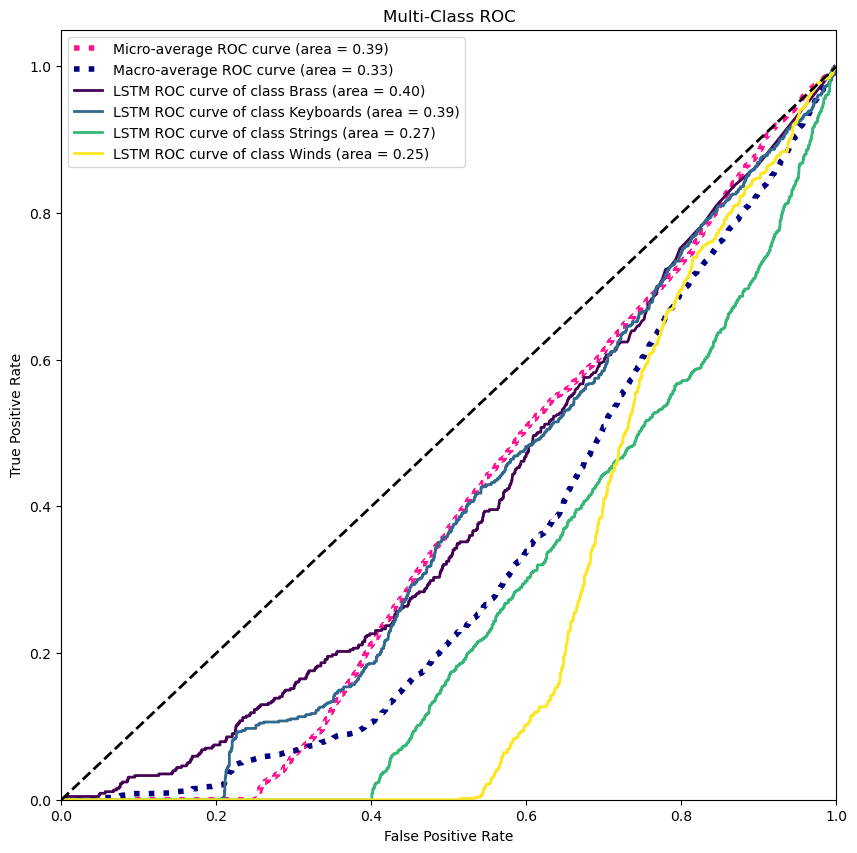

In [113]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pylab
import seaborn as sns

y_pred = np.load('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/logs/y_pred.npy')

wav_paths = glob('{}/**'.format('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification_by_family'), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x and '.DS_Store' not in x])


classes = sorted(os.listdir('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification_by_family'))
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
le = LabelEncoder()

y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x-1] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

n_classes = len(set(y_true))

# Add an extra column of zeros to y_hot to match the model's expected 15 classes
y_hot_expanded = np.zeros((y_hot.shape[0], y_hot.shape[1] + 1))
y_hot_expanded[:,:-1] = y_hot


colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(labels)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot_expanded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot_expanded.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the interpolated TPR and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for individual classes
colors = pylab.cm.viridis(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='LSTM ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc="upper left")
plt.show()


Confusion Matrix Summaries:
Model: Conv2D
+-----------+---------+-----------+---------+
|   Class   | Correct | Incorrect | Samples |
+-----------+---------+-----------+---------+
|   Brass   |   455   |     0     |   455   |
| Keyboards |   689   |     0     |   689   |
|  Strings  |   1193  |     0     |   1193  |
|   Winds   |   576   |     0     |   576   |
+-----------+---------+-----------+---------+


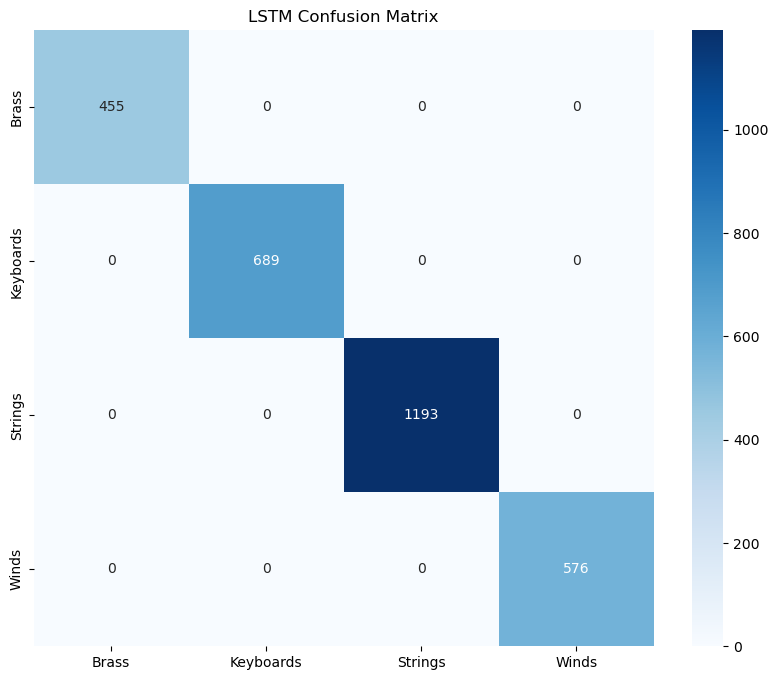

In [114]:
from prettytable import PrettyTable
# confusion matrix 
unique_labels = sorted(list(set(y_true_labels + y_pred_labels)))

# Generate the confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)

summary = []


# Calculate correct predictions and total samples for each class
for i, label in enumerate(unique_labels):
    true_positives = conf_mat[i, i]
    false_positives = sum(conf_mat[:, i]) - true_positives
    false_negatives = sum(conf_mat[i, :]) - true_positives
    incorrect_predictions = false_positives + false_negatives
    total_samples = true_positives + false_negatives
    
    summary.append({
        "Class": label,
        "Correct": true_positives,
        "Incorrect": incorrect_predictions,
        "Samples": total_samples
    })

# Create a PrettyTable object
x = PrettyTable()

# Add the column names
x.field_names = ["Class", "Correct", "Incorrect", "Samples"]

# Add rows from the summary list
for row in summary:
    x.add_row([row["Class"], row["Correct"], row["Incorrect"], row["Samples"]])

# Set the title of the table
print("Confusion Matrix Summaries:")
print(f"Model: Conv2D")  # replace with your actual model name
print(x)



# Convert the confusion matrix to a DataFrame
df_cm = pd.DataFrame(conf_mat, index=unique_labels, columns=unique_labels)

plt.figure(figsize = (10,8))
plt.title('LSTM Confusion Matrix')
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.show()

In [90]:
pip install prettytable


  Obtaining dependency information for prettytable from https://files.pythonhosted.org/packages/4d/81/316b6a55a0d1f327d04cc7b0ba9d04058cb62de6c3a4d4b0df280cbe3b0b/prettytable-3.9.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [115]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define the column names
table.field_names = ["Model", "Accuracy", "Precision", "F1 Score"]

# Add rows to the table with your hardcoded data
table.add_row(["Conv1D", "0.9867", "0.9643", "0.9832"])
table.add_row(["Conv2D", "0.9865", "0.9722", "0.9839"])
table.add_row(["LSTM", "0.9779", "0.9622", "0.9783"])

# Align columns to the left
table.align = "l"

# Print the table
print("  CNN Model Performance Summary:")
print(table)


  CNN Model Performance Summary:
+--------+----------+-----------+----------+
| Model  | Accuracy | Precision | F1 Score |
+--------+----------+-----------+----------+
| Conv1D | 0.9867   | 0.9643    | 0.9832   |
| Conv2D | 0.9865   | 0.9722    | 0.9839   |
| LSTM   | 0.9779   | 0.9622    | 0.9783   |
+--------+----------+-----------+----------+
